In [30]:
import os
import cv2
import numpy
import pandas as pd
import seaborn as sns
import imageio
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution3D, MaxPooling3D
from keras.optimizers import SGD, RMSprop
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils, generic_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from keras import backend as K
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import sys
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [29]:
K.set_image_data_format('channels_first')
image_rows, image_columns, image_depth = 64, 64, 96
look_frames = int(image_depth/2)
num_classes = 3 # 分類類別 
process_detect = False # 要不要對資料做 detect 處理
version = True # F:舊版(39筆) 或 T:新版(269筆)


training_list = []
apexframe   = [[] for a in range(num_classes)] # 紀錄video的apex frame
ifsamevideo = [[] for a in range(num_classes)] # 紀錄clip與其前一個clip是否來自相同video
path = [[] for a in range(num_classes)]

if version:
    # anger
    apexframe[0]   = [572,2163,3371,3757,569,1675,1758,421,1391,1881,2162,2912,3421,3943,3270,1898,3447,3309,3563,1139,1979,2168,
                      2247,2641,3733,415,933,870,1694,2139,2197,3493,3808,416,587,886,1331,1529,1660,1716,1538,2281,2783,3210,
                      3405,3772,4031,3689,4343,3405]
    ifsamevideo[0] = [1,0,1,1,0,1,1,0,1,1,1,1,1,1,0,0,1,0,1,0,1,1,1,0,1,0,1,0,1,1,1,1,1,0,1,1,1,1,1,1,0,1,1,1,1,1,1,0,1,0]
    # happiness
    apexframe[1]   = [142,2218,2476,1412,329,1114,1415,1480,2207,77,400,997,1148,1358,1604,1703,1886,2261,858,1584,2291,2344,
                      3180,1771,2986,993,1137,1432,2774,115,2753,858,1094,1597,1875,848,1431,1658,1842,1957,2237,2697,3181,872,
                      966,140,203,183,341,569,1102,1451,2203,368,423,2234,1184,1779,1938,200,179,347,859,1195,1582,1936,1438,
                      1562,1166,2259,1691,3193,1616,2203,1054,2253,775,410,873,1590,2218,264,363,666,739,1105,1579,1764,2092,
                      2465,2683,1726,2234,1671,2338,1015,373,582,1087,861,1868,423,1182,1490,1963,2242,861,1587,1762,2044,2357,
                      2709,244,423,342,888,1197,1800,1882,1250,1390,1675,1790,1881,2239,613,1613,2707]
    ifsamevideo[1] = [1,1,0,0,0,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,1,1,0,0,0,1,1,0,0,0,0,1,1,1,0,1,1,1,1,1,1,1,0,1,0,1,0,1,1,1,1,1,
                      0,1,1,0,1,1,0,0,1,1,1,1,1,0,1,0,1,0,1,0,0,0,1,0,0,1,1,1,0,1,1,1,1,1,1,1,1,1,0,1,0,1,0,0,1,1,0,1,0,1,1,1,1,
                      0,1,1,1,1,1,0,1,0,1,1,1,1,0,1,1,1,1,1,0,1,0]
    # disgust
    apexframe[2]   = [703,559,1799,214,334,430,535,727,841,177,376,391,525,1571,1716,1840,316,912,335,530,732,925,1364,478,1003,
                      1017,321,434,428,880,1207,1713,39,377,559,804,1061,1460,357,785,412,572,756,1107,1426,1582,789,66,106,1296]
    ifsamevideo[2] = [1,0,1,0,1,1,1,1,0,0,0,1,1,1,1,1,0,1,0,1,1,1,0,0,1,0,0,1,0,1,1,1,0,1,1,1,1,0,0,1,0,1,1,1,1,1,0,0,0,0]

    path[0] = 'data-all/anger/'      #  50  video clips
    path[1] = 'data-all/happiness/'  #  128 video clips
    path[2] = 'data-all/disgust/'    #  50  video clips
    
else:
    # anger
    apexframe[0]   = [1898, 3447, 1139, 1979, 933, 1694, 2197, 3808]
    ifsamevideo[0] = [1, 1, 0, 1, 0, 0, 1, 1]
    # happiness
    apexframe[1]   = [142, 329, 400, 1703, 1886, 2291, 1842, 1957, 3239, 619, 423, 1054, 264, 423, 2239] 
    ifsamevideo[1] = [1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]
    # disgust
    apexframe[2]   = [703, 559, 275, 335, 530, 732, 1003, 1013, 1024, 880, 39, 377, 1460, 1426, 1037, 106] 
    ifsamevideo[2] = [1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0]

    path[0] = 'data/angry/'    # 8  video clips
    path[1] = 'data/happy/'    # 15 video clips
    path[2] = 'data/disgust/'  # 16 video clips

cascade_classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# 資料存檔/ 載入路徑
if process_detect:
    if version: imagefile = 'images_detect_new.npy'
    else: imagefile       = 'images_detect_old.npy'
else:
    if version: imagefile = 'images_new.npy'
    else: imagefile       = 'images_old.npy'

In [3]:
def video_clips(detect):
    for v in range(num_classes):
        k = 0 # index of directorylisting
        directorylisting = os.listdir(path[v])
        for i in range(len(apexframe[v])):
            if ifsamevideo[v][i] == False: # 目前短片與上一個短片來自不同影片，index k++
                k = k + 1
            video = directorylisting[k]
            videopath = path[v] + video
            loadedvideo = imageio.get_reader(videopath, 'ffmpeg')
            length = loadedvideo.count_frames() # 影片最大幀數

            # 邊界處理
            apex = apexframe[v][i]
            left  = apex - look_frames # 左 偏移量
            right = apex + look_frames # 右 偏移量
            if right > length:
                right = length
                left  = right - image_depth
            elif left < 0:
                left  = 0
                right = left + image_depth
            print("{:40}  left{:5}  apex{:5}  right{:5}". format(video, left, apex, right))

            # 沒有對資料做 detect 一樣的處理
            if detect == False:
                frames = [] 
                framerange = [x for x in range(left, right)] # 取apex frame的前後幾幀     
                for frame in framerange:
                    image = loadedvideo.get_data(frame)
                    imageresize = cv2.resize(image, (image_rows, image_columns), interpolation = cv2.INTER_AREA)
                    grayimage = cv2.cvtColor(imageresize, cv2.COLOR_BGR2GRAY)
                    frames.append(grayimage)
                """
                # 印出apex前後共15幀
                count = 0
                framerange = [apex + i for i in range(-7, 8)] 
                plt.figure(figsize=(15, 2))
                for frame in framerange:
                    count += 1
                    image = loadedvideo.get_data(frame)
                    imageresize = cv2.resize(image, (image_rows, image_columns), interpolation=cv2.INTER_AREA)
                    plt.subplot(1, 15, count)
                    plt.imshow(imageresize)
                    plt.axis('off') # 關閉刻度
                plt.tight_layout()
                plt.show()
                """
                
                frames = numpy.asarray(frames)
                videoarray = numpy.rollaxis(numpy.rollaxis(frames, 2, 0), 2, 0)
                training_list.append(videoarray)


            #對資料做 detect 一樣的處理    
            elif detect == True: 
                frames = [] 
                framerange = [x for x in range(left, right)] # 取apex frame的前後幀
                frame_count = 0 # 紀錄每個輸入影片的幀數
                for frame in framerange: # 將資料改為跟Detect一樣
                    image = loadedvideo.get_data(frame)
                    grayimage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                    face_rects = cascade_classifier.detectMultiScale(grayimage, 1.2, 6) # 人臉偵測
                    for (x,y,w,h) in face_rects: # 偵測的框架
                        gray_roi = grayimage[y:y+h, x:x+w] # 框架區域
                        imageresize = cv2.resize(gray_roi, (image_rows, image_columns), interpolation = cv2.INTER_AREA)
                        frames.append(imageresize)
                        last_frame = imageresize # 紀錄最後一幀
                        frame_count += 1

                for a in range(frame_count, image_depth): # 不足96幀數的影片，都用最後一幀補滿
                    frames.append(last_frame)

                frames = numpy.asarray(frames)
                videoarray = numpy.rollaxis(numpy.rollaxis(frames, 2, 0), 2, 0)
                training_list.append(videoarray)
                print("影片", i+1, numpy.asarray(videoarray).shape)

                plt.figure(figsize=(1, 1))
                plt.imshow(last_frame)
                plt.show()


video_clips(process_detect)  
numpy.save(imagefile, training_list)

37_0402beatingpregnantwoman.avi           left  524  apex  572  right  620
27_0402beatingpregnantwoman.avi           left 2115  apex 2163  right 2211
27_0402beatingpregnantwoman.avi           left 3323  apex 3371  right 3419
27_0402beatingpregnantwoman.avi           left 3709  apex 3757  right 3805
24_0402beatingpregnantwoman.avi           left  521  apex  569  right  617
24_0402beatingpregnantwoman.avi           left 1627  apex 1675  right 1723
24_0402beatingpregnantwoman.avi           left 1710  apex 1758  right 1806
16_0401girlcrashing.avi                   left  373  apex  421  right  469
16_0401girlcrashing.avi                   left 1343  apex 1391  right 1439
16_0401girlcrashing.avi                   left 1833  apex 1881  right 1929
16_0401girlcrashing.avi                   left 2114  apex 2162  right 2210
16_0401girlcrashing.avi                   left 2864  apex 2912  right 2960
16_0401girlcrashing.avi                   left 3373  apex 3421  right 3469
16_0401girlcrashing.avi  

In [4]:
for i in apexframe:
    print(len(i))
    
training_list = numpy.load(imagefile)

50
128
50


In [5]:
training_list = numpy.asarray(training_list)
trainingsamples = len(training_list)

# 設定label
traininglabels = numpy.zeros((trainingsamples, ), dtype = int) 
if version:
    traininglabels[0:50] = 0     # 50  video clips (anger)
    traininglabels[50:178] = 1   # 128 video clips (happiness)
    traininglabels[178:228] = 2  # 50  video clips (disgust)
else:
    traininglabels[0:8] = 0      #  8  video clips (anger)
    traininglabels[8:23] = 1     # 15  video clips (happiness)
    traininglabels[23:39] = 2    # 16  video clips (disgust)
traininglabels = np_utils.to_categorical(traininglabels, num_classes) # one-hot編碼

# 資料轉為五維
training_set = numpy.zeros((trainingsamples, 1, image_rows, image_columns, image_depth))
for h in range(trainingsamples):
    training_set[h][0][:][:][:] = training_list[h,:,:,:]
print(training_set.shape)

# 資料處理 標準化
training_set = training_set.astype('float32')
training_set -= numpy.mean(training_set) # 消除數據的偏差 (與其他資料集相比)
training_set /= numpy.max(training_set)  # 使數據介於0~1之間

(228, 1, 64, 64, 96)


In [6]:
def CNN_3D():
    model = Sequential()
    model.add(Convolution3D(32, (3, 3, 15), input_shape=(1, image_rows, image_columns, image_depth), activation='relu'))
    model.add(MaxPooling3D(pool_size=(3, 3, 3)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer = 'SGD', metrics = ['accuracy'])
    return model

CNN_3D().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 32, 62, 62, 82)    4352      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 32, 20, 20, 27)   0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 20, 20, 27)    0         
                                                                 
 flatten (Flatten)           (None, 345600)            0         
                                                                 
 dense (Dense)               (None, 128)               44236928  
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                        

2024-05-27 13:49:04.004732: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-27 13:49:04.004876: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/infor/miniconda3/envs/torch/lib/python3.9/site-packages/cv2/../../lib64:
2024-05-27 13:49:04.004920: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/infor/miniconda3/envs/torch/lib/python3.9/site-packages/cv2/../../lib64:
2024-05-27 13:49:04.004950: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcub

Round 1 complete
Round 2 complete
Round 3 complete
Round 4 complete
Round 5 complete
Round 6 complete
Round 7 complete
Round 8 complete
Round 9 complete
Round 10 complete
Round 11 complete
Round 12 complete
Round 13 complete
Round 14 complete
Round 15 complete
Round 16 complete
Round 17 complete
Round 18 complete
Round 19 complete
Round 20 complete
Round 21 complete
Round 22 complete
Round 23 complete
Round 24 complete
Round 25 complete
Round 26 complete
Round 27 complete
Round 28 complete
Round 29 complete
Round 30 complete
Round 31 complete
Round 32 complete
Round 33 complete
Round 34 complete
Round 35 complete
Round 36 complete
Round 37 complete
Round 38 complete
Round 39 complete
Round 40 complete
Round 41 complete
Round 42 complete
Round 43 complete
Round 44 complete
Round 45 complete
Round 46 complete
Round 47 complete
Round 48 complete
Round 49 complete
Round 50 complete
Accuracy: 0.1040
              precision    recall  f1-score   support

           0       0.00      0.00    

/home/infor/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/infor/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/infor/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

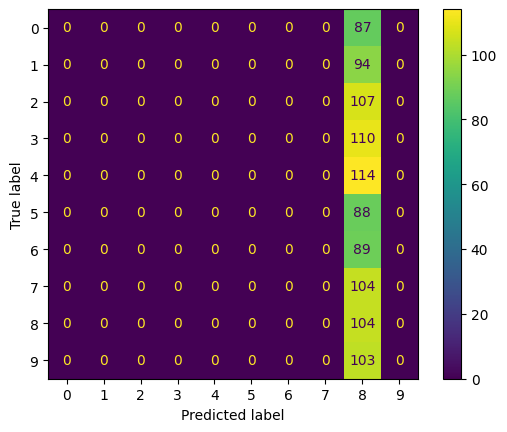

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

class SimpleNN:
    def __init__(self, input_size, hidden_size, output_size):
        self.weights1 = np.random.rand(input_size, hidden_size)
        self.bias1 = np.random.rand(hidden_size)
        self.weights2 = np.random.rand(hidden_size, output_size)
        self.bias2 = np.random.rand(output_size)
    
    def forward(self, x):
        self.z1 = np.dot(x, self.weights1) + self.bias1
        self.a1 = self.relu(self.z1)
        self.z2 = np.dot(self.a1, self.weights2) + self.bias2
        return self.softmax(self.z2)
    
    def relu(self, x):
        return np.maximum(0, x)
    
    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # Stability improvement
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    def backward(self, x, y, output, learning_rate):
        output_error = output - y
        d_weights2 = np.dot(self.a1.T, output_error)
        d_bias2 = np.sum(output_error, axis=0)
        
        hidden_error = np.dot(output_error, self.weights2.T) * (self.a1 > 0)
        d_weights1 = np.dot(x.T, hidden_error)
        d_bias1 = np.sum(hidden_error, axis=0)
        
        self.weights1 -= learning_rate * d_weights1
        self.bias1 -= learning_rate * d_bias1
        self.weights2 -= learning_rate * d_weights2
        self.bias2 -= learning_rate * d_bias2

# FedAvg function
def fed_avg(models):
    avg_model = SimpleNN(input_size, hidden_size, output_size)
    num_models = len(models)
    
    avg_model.weights1 = np.mean([model.weights1 for model in models], axis=0)
    avg_model.bias1 = np.mean([model.bias1 for model in models], axis=0)
    avg_model.weights2 = np.mean([model.weights2 for model in models], axis=0)
    avg_model.bias2 = np.mean([model.bias2 for model in models], axis=0)
    
    return avg_model

# Simulated training data (for demonstration purposes)
def generate_data(num_samples, input_size, output_size):
    X = np.random.rand(num_samples, input_size)
    y = np.eye(output_size)[np.random.choice(output_size, num_samples)]
    return X, y

# Training function
def train(model, X, y, epochs, learning_rate):
    for epoch in range(epochs):
        output = model.forward(X)
        model.backward(X, y, output, learning_rate)

# Main federated learning training loop
NUM_CLIENTS = 10
NUM_ROUNDS = 50
input_size = 100  # Example input size
hidden_size = 64  # Example hidden layer size
output_size = 10  # Example number of classes
learning_rate = 0.1
epochs = 5

# Initialize models for each client
client_models = [SimpleNN(input_size, hidden_size, output_size) for _ in range(NUM_CLIENTS)]

for round_num in range(NUM_ROUNDS):
    # Simulate client training
    for client_model in client_models:
        X_train, y_train = generate_data(100, input_size, output_size)  # Example training data
        train(client_model, X_train, y_train, epochs, learning_rate)
    
    # Aggregate the models using FedAvg
    global_model = fed_avg(client_models)
    
    # Update client models with the global model
    for client_model in client_models:
        client_model.weights1 = np.copy(global_model.weights1)
        client_model.bias1 = np.copy(global_model.bias1)
        client_model.weights2 = np.copy(global_model.weights2)
        client_model.bias2 = np.copy(global_model.bias2)
    
    print(f'Round {round_num + 1} complete')

# Example of using the trained global model
X_test, y_test = generate_data(1000, input_size, output_size)  # Example test data
predictions = global_model.forward(X_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Calculate accuracy
accuracy = np.mean(predicted_labels == true_labels)
print(f'Accuracy: {accuracy:.4f}')

# Classification report
print(classification_report(true_labels, predicted_labels))

# Confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(output_size))
disp.plot()
plt.show()
